In [1]:
%load_ext autoreload
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

from SavedModel import SavedModel
from utils import languages, get_trigrams_sets, encode, prepare_dataframe, normalize, \
    FFN_Hyperparams, build_model, create_encoder, test_model, create_feature_dictionary, sentences_by_lang
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

### Przygotowanie danych

In [2]:
print(languages)
print(sentences_by_lang)

['eng', 'deu', 'spa', 'ita', 'por']
200000


In [3]:
df = prepare_dataframe()

In [4]:
all_trigrams, _ = get_trigrams_sets(df)

### Bag of words

In [5]:
# Tworzymy bag of words, nie wykorzystujemy binarnego bag of words ponieważ trigramy w zdaniu mogą się powtórzyć i stracilibyśmy tę informację.
# Wadą BoW jest fakt, że każdy trigram jest tak samo ważny, ale w naszym problemie to nie przeszkadza.
dic = create_feature_dictionary(all_trigrams)

vectorizer = CountVectorizer(vocabulary=dic, ngram_range=(3,3), analyzer="char") #ngram_range bierzemy tylko trigramy, analyzer bierzemy pod uwagę znaki,// char_wb nie zliczało poprawnie kolumn
sentences = df["sentence"]
langs = df["lang"]
X = vectorizer.fit_transform(sentences)
# Tworzymy macierz wystąpień poszcególnych trigramów
features = pd.DataFrame(data=X.toarray(), columns=all_trigrams)

### Normalizacja

In [6]:
features = normalize(features)
features["lang"] = list(langs) # dodajemy dodatkową kolumnę z naszym outputem

### Podział na dane testowe i treningowe

In [7]:
encoder = create_encoder()
x = features.drop('lang',axis=1)
y = encode(features['lang'], encoder)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

### Przygotowanie modelu

In [8]:
params = FFN_Hyperparams(len(X_train.columns), len(languages), [500,500,250], 'relu')
model = build_model(params)

### INFO o urządzeniach

In [9]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Uruchomienie treningu

In [10]:
from tensorflow.keras.utils import Sequence
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

In [11]:
# Z użyciem gpu
#with tf.device('/GPU:0'):


# Sample - jeden wiersz danych wejściowych - jeden przykład.
# Batch - po ilu samplach, które przeszły przez sieć zaktualizować wagi.
# Batch Gradient Descent. Batch Size = Size of Training Set
# Stochastic Gradient Descent. Batch Size = 1
# Mini-Batch Gradient Descent. 1 < Batch Size < Size of Training Set
# Epoch - ile razy cały training set przeszedł przez sieć.
# Learning rate - jak szybko funkcja kosztu schodzi do minimum
train_gen = DataGenerator(X_train, y_train, 32)
length = int(len(X_train)/2)
history = model.fit(train_gen, epochs=6, batch_size=6)

Epoch 1/6
25000/25000 [==============================] - 112s 4ms/step - loss: 0.0772 - accuracy: 0.9713
Epoch 2/6
25000/25000 [==============================] - 111s 4ms/step - loss: 0.0500 - accuracy: 0.9810
Epoch 3/6
25000/25000 [==============================] - 109s 4ms/step - loss: 0.0453 - accuracy: 0.9846
Epoch 4/6
25000/25000 [==============================] - 105s 4ms/step - loss: 0.0348 - accuracy: 0.9868
Epoch 5/6
25000/25000 [==============================] - 108s 4ms/step - loss: 0.0313 - accuracy: 0.9886
Epoch 6/6
25000/25000 [==============================] - 110s 4ms/step - loss: 0.0273 - accuracy: 0.9897


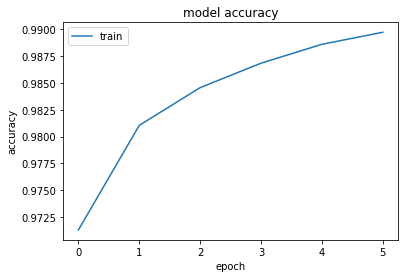

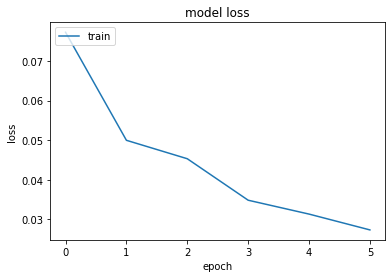

In [12]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Test precyzji

In [13]:
accuracy = test_model(model, encoder, X_test, y_test)

6250/6250 [==============================] - 27s 1ms/step


In [14]:
print("Accuracy: ", accuracy)
if accuracy > 0.8:
    model.save("trigrams_recognition")
    with open('trigrams_labels.pkl', 'wb') as f:
        pickle.dump(encoder.classes_, f)
    with open('trigrams_vectorizer.pkl', 'wb') as f:
        pickle.dump(vectorizer, f)

Accuracy:  0.98366
INFO:tensorflow:Assets written to: trigrams_recognition\assets
